# **Data Preparation**
*This notebook contains the data preparation of the data provided by the [IBM Call for Code Wildfire Challenge](https://community.ibm.com/community/user/datascience/blogs/susan-malaika/2020/11/10/call-for-code-spot-challenge-for-wildfires).
*The original data is available [on GitHub](https://github.com/Call-for-Code/Spot-Challenge-Wildfires), the preprocessed .csv-files are available [here](https://github.com/Call-for-Code/Spot-Challenge-Wildfires).*

The notebook consists of the following process steps:


*   loading csv data (wildfires, weather, forecasts, landclass and vegetation index)
*   reformatting weather data one line per date
*   adding fix data to landclass
*   handle missing values in time series per region
*   handling outliers
*   merging data
*   generating new indicators






In [45]:
import sys
import os
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats

from google.colab import drive

drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Wildfire_Challenge/Data')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


*   loading csv data (wildfires, weather, forecasts, landclass and vegetation index)

In [46]:
wildfires_df = pd.read_csv('Historical_Wildfires.csv')
weather_df = pd.read_csv('HistoricalWeather.csv')
forecasts_df = pd.read_csv('HistoricalWeatherForecasts.csv')
landclass_df = pd.read_csv('LandClass.csv')
vegetation_df = pd.read_csv('VegetationIndex.csv')

forecasts_df['Date'] = pd.to_datetime(forecasts_df['Date'])
wildfires_df['Date'] = pd.to_datetime(wildfires_df['Date'])
weather_df['Date'] = pd.to_datetime(weather_df['Date'])
vegetation_df['Date'] = pd.to_datetime(vegetation_df['Date'])

In [47]:
##### ADD FIX DATA TO LANDCLASS #####
temp_df = pd.DataFrame.drop_duplicates(weather_df[['Region','count()[unit: km^2]']])
landclass_df = pd.merge(landclass_df, temp_df)

##### REPLACE ZEROES WITH NAN #####
#wildfires_df = wildfires_df.mask(wildfires_df==0)
wildfires_df = wildfires_df.drop(columns = ['Replaced', 'Count'])

*    Reformatting data to one line per date and region

In [48]:
def reformat_weather_data(df):
    df = df.rename(columns={"count()[unit: km^2]": "Area", "min()": "Min", "max()": "Max", "mean()": "Mean", "variance()": "Variance"})

    # Reformat the Data
    df_pivot = df.pivot_table(values=['Min','Max','Mean','Variance'], index=['Date','Region'], columns=['Parameter'])

    # Reset dataframe index
    df_pivot.reset_index(inplace=True)

    # Renaming Column names
    df_pivot.columns = [col[0] if not(col[1]) else '{1}_{0}'.format(*col) for col in df_pivot.columns.values]

    # Rearranging Data and column
    params = df_pivot.columns.tolist()[3:]
    params.sort()
    
    return df_pivot[df_pivot.columns.tolist()[:3] + params].copy()

weather_df = reformat_weather_data(weather_df)
forecasts_df = reformat_weather_data(forecasts_df)

*     Handling missing values with interpolation of time series

In [49]:
def fill_frames(df, columns):
    df_all = pd.DataFrame()
    for region in landclass_df.Region:
      df_temp = df[df['Region'] == region]
      #add missing dates
      df_temp = df_temp.resample('1D', on='Date').first().drop('Date', 1).reset_index()
      #fill region new rows with region
      df_temp[['Region']] = df_temp[['Region']].fillna(value = region)
      #fill remaining columns with linear interpolated values
      df_temp[columns]=df_temp[columns].interpolate(method='linear', direction = 'backward')
      # fill first / second columns with backward and forward filling, since they could not be calculated with linear interpolation
      df_temp = df_temp.fillna(method='ffill')
      df_temp = df_temp.fillna(method='bfill')
      df_all = df_all.append(df_temp)
    return df_all

forecasts_df.drop_duplicates(inplace = True)
forecasts_columns = ['Precipitation_Max', 'Precipitation_Mean', 'Precipitation_Min', 'Precipitation_Variance', 'RelativeHumidity_Max', 'RelativeHumidity_Mean', 'RelativeHumidity_Min', 'RelativeHumidity_Variance', 'SolarRadiation_Max', 'SolarRadiation_Mean', 'SolarRadiation_Min', 'SolarRadiation_Variance', 'Temperature_Max', 'Temperature_Mean', 'Temperature_Min', 'Temperature_Variance', 'WindSpeed_Max', 'WindSpeed_Mean', 'WindSpeed_Min', 'WindSpeed_Variance']
forecasts_df = fill_frames(forecasts_df, forecasts_columns)

veg_columns = ['Vegetation_index_mean', 'Vegetation_index_max', 'Vegetation_index_min', 'Vegetation_index_std', 'Vegetation_index_variance']
vegetation_df = fill_frames(vegetation_df, veg_columns)

*     Merging data

In [50]:
weather_columns = ['Precipitation_Max','Precipitation_Mean','Precipitation_Min','Precipitation_Variance','RelativeHumidity_Max','RelativeHumidity_Mean','RelativeHumidity_Min','RelativeHumidity_Variance','SoilWaterContent_Max','SoilWaterContent_Mean','SoilWaterContent_Min','SoilWaterContent_Variance','SolarRadiation_Max','SolarRadiation_Mean','SolarRadiation_Min','SolarRadiation_Variance','Temperature_Max','Temperature_Mean','Temperature_Min','Temperature_Variance', 'WindSpeed_Max','WindSpeed_Mean','WindSpeed_Min','WindSpeed_Variance']
vegetation_columns = ['Vegetation_index_mean', 'Vegetation_index_max', 'Vegetation_index_min', 'Vegetation_index_std', 'Vegetation_index_variance']
wildfire_columns = ['Estimated_fire_area', 'Mean_estimated_fire_brightness', 'Mean_estimated_fire_radiative_power']

df_all = pd.DataFrame()
for region in landclass_df.Region:
  df_temp = wildfires_df[wildfires_df['Region'] == region]
  #add missing dates
  df_temp = df_temp.resample('1D', on='Date').first().drop('Date', 1).reset_index()

  #generate data frames for dates on the edge of the datasets to unify the start dates per region
  df_date = pd.DataFrame()
  df_date['Date'] = pd.date_range('2021-01-20', periods=12, freq='D')
  df_temp = df_temp.merge(df_date, how='outer', on=['Date'])

  df_datebegin = pd.DataFrame()
  df_datebegin['Date'] = pd.date_range('2005-01-01', periods=12, freq='D')
  df_temp = df_datebegin.merge(df_temp, how='outer', on=['Date'])

  df_temp = df_temp.merge(weather_df, how='left', on=['Date', 'Region'])
  df_temp.drop(columns=['Mean_confidence', 'Std_confidence', 'Var_confidence'], inplace=True)
  
  df_temp[['Region']] = df_temp[['Region']].fillna(value = region)
  df_temp = df_temp.merge(vegetation_df, how='left', on=['Date', 'Region'])
  df_temp = df_temp.merge(landclass_df, how='left', on=['Region'])

  #filling missing weather data with forecast data
  df_temp = df_temp.set_index(['Date','Region']).fillna(forecasts_df.set_index(['Date','Region'])).reset_index()

  #fill remaining missing values with linear interpolation, backward and forward filling
  df_temp[vegetation_columns] = df_temp[vegetation_columns].fillna(method='ffill')
  df_temp[wildfire_columns] = df_temp[wildfire_columns].fillna(0)
  df_temp[weather_columns]=df_temp[weather_columns].interpolate(method='linear', direction = 'backward')
  df_temp[weather_columns]=df_temp[weather_columns].interpolate(method='linear', direction = 'backward', limit_direction ='backward')

  df_all = df_all.append(df_temp)

*     handling outliers

In [39]:
for col in df_all.columns:
  if col in ['Estimated_fire_area','Mean_estimated_fire_radioative_power', 'Precipitation_Max','Precipitation_Min','Precipitation_Mean', 'Precipitation_Variance','Relative_Humidity_Variance','SoilWaterContent_Min','SolarRadiation_Variance','Temperature_Variance','WindSpeed_Max','WindSpeed_Mean','WindSpeed_Variance']:
    if col in ['SoilWaterContent_Min', 'Precipitation_Max', 'Precipitation_Min', 'Precipitation_Variance']:
      scipy.stats.mstats.winsorize(df_all[col], limits = 0.10, inplace = True)
    else: 
      scipy.stats.mstats.winsorize(df_all[col], limits = 0.05, inplace = True)


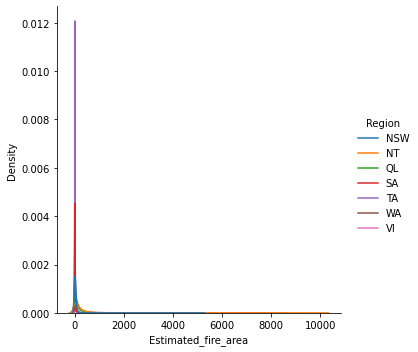

In [51]:
g = sns.displot(data=df_all.iloc[:, :-16], x='Estimated_fire_area', hue="Region", kind="kde")

*     adding new ratios

In [ ]:
# the lower the vegetation index, the drier is the vegetation
vegetation_influenced_columns = ['Shrubs', 'Herbaceous vegetation', 'Cultivated and managed vegetation/agriculture (cropland)', 'Herbaceous wetland', 'Closed forest, deciduous broad leaf', 'Closed forest, unknown', 'Open forest, deciduous broad leaf', 'Open forest, unknown definitions']
other_landclass_columns = ['Urban / built up','Bare / sparse vegetation','Permanent water bodies','Closed forest, evergreen, broad leaf','Open forest, evergreen broad leaf','Open sea','count()[unit: km^2]']

for col in vegetation_influenced_columns:
  df_all[col+'_inflame_risk'] = df_all[col] * (1-df_all.Vegetation_index_mean)
  df_all = df_all.drop(columns = col)

df_all = df_all.drop(columns = other_landclass_columns)

In [ ]:
def segregate_date(df):
    df["Month"] = df["Date"].dt.month
    df["Year"] = df["Date"].dt.year
    return df

df_all = segregate_date(df_all)
forecasts_df = segregate_date(forecasts_df)

*     Store preprocessed data to .csv-Files

In [ ]:
df_all.to_csv('Cleansed_Data.csv', index = False)
landclass_df.to_csv('Cleansed_LandClass.csv', index = False)
forecasts_df.to_csv('Cleansed_Forecasts.csv', index = False)